# Multi-objective optimisation of reservoir release scheduling

## Reservoir system

<left><img src="Images/System 1 layout.png" width = "500px"><left>

## Operation approach

a)	Constraint: Releases always meet the estimated demand

b)	Objective: Wimbleball storage at 1 April must be maximum.

c)	Constraint: Storage always over the historical minimum.

d)  Objective: To minimize pumping cost

In [1]:
# Work folder
folderpath='..//'

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
from calendar import monthrange
from platypus import NSGAII, Problem, Real,NSGAII_v2,NSGAII_v3 #Optimizer
import seaborn as sns
sns.set()
import ipywidgets as widgets
import sys

## Import submodules

In [2]:
sys.path.append('../Submodules')
from WRSM_functions import reservoir_simulation_1,reservoir_simulation_2 # Water system operation module
from Seasonal_forecast_v2 import Seasonal_forecast_v2 # Seasonal forecast data module
from Current_reservoir_volume import Current_reservoir_volume # To obtain the reservoir volume
from Demand_model import Demand_model
from Control_curve import Control_curve
from Observed_inflow_data import Observed_inflow_data
from Historical_storage_envelope import Historical_storage_envelope
from Observed_pumping_cost import Observed_pumping_cost
from ESP_forecast import ESP_forecast

ModuleNotFoundError: No module named 'WRSM_functions'

In [ ]:
# Excel date correction
day_num_corr = 2 # correction of the day number (since 01/01/1900) given by Excel

## Starting options

In [165]:
# Definition of the initial date, forecast lead time and the length of the simulation
# Please choose a date corresponding to a Monday otherwise the system will automatically choose the closer Monday of the selected month
year0 = 2009
month0 = 12
day0 = 1
horizon = 17 # forecast lead time in number of weeks
sim_time = 12 # number of weeks to simulate
sf_provider = 'ECMWF'

### Selection of the type of forecast

In [166]:
forecast = widgets.ToggleButtons(
    options=['ESP mean', 'ESP ensemble', 'Seasonal forecast mean', 'Seasonal forecast ensemble','Perfect forecast'],
    description='Forecast type:',
    disabled=False,
    button_style='',
    tooltips=['Mean of the ESP', 'ESP ensemble', 'Mean of the seasonal forecast ensemble','Seasonal forecast ensemble','Perfect forecast'],
)
display(forecast)

A Jupyter Widget

### Selection of the decision priority

In [167]:
decision = widgets.ToggleButtons(
    options=['Max res', 'Balanced - Mean', 'Min pump'],
    description='Decision priority:',
    disabled=False,
    button_style='',
    tooltips=['Maximize resource availability by 1 April', 'Balanced approach', 'Minimize pumping costs'],
)
display(decision)

A Jupyter Widget

In [7]:
# Selection of the bias correction method
BC = widgets.ToggleButtons(
    options=['No BC', 'LS', 'QM'],
    description='Bias correction method:',
    disabled=False,
    button_style='',
    tooltips=['No bias correction', 'Linear scaling', 'Quantile mapping'],
)
display(BC)

A Jupyter Widget

## Data

### Catchment area

In [168]:
# Wimbleball
area_W = 28.8 # km2
# Clatworthy
area_C = 18.2 # km2
# Exe river
area_E = 358 # km2

### Max and Min storage volume

In [169]:
# Wimbleball
s_max_S1 = 21543.5 # ML
s_min_S1 = 233 # ML
s2elev_S1 = [3.849,0.2569] # water storage to elevation factors
elev2area_S1 = [4250,1.5] # water elevation to surface area factors
# Clatworthy
s_max_S2 = 5662.21 # ML
s_min_S2 = 564.3 # ML
s2elev_S2 = [1.564,0.3418] # water storage to elevation factors
elev2area_S2 = [3200,1.5] # water elevation to surface area factors

### Weekly inflow forecast

In [170]:
# Wimbleball
I_S1_date, I_S1,Rain, Temp, PET = Seasonal_forecast_v2(sf_provider,year0,month0,day0,horizon,area_W,BC.get_interact_value())
# Clatworthy
I_S2_date, I_S2,Rain, Temp, PET = Seasonal_forecast_v2(sf_provider,year0,month0,day0,horizon,area_C,BC.get_interact_value())
# Exe river
I_R1_date, I_R1,Rain, Temp, PET = Seasonal_forecast_v2(sf_provider,year0,month0,day0,horizon,area_E,BC.get_interact_value())
I_R2 = I_R1/0.746

if forecast.get_interact_value() == "Seasonal forecast mean":
    I_S1 = np.reshape(np.mean(I_S1,axis = 1),[np.size(np.mean(I_S1,axis = 1)),1])
    I_S2 = np.reshape(np.mean(I_S2,axis = 1),[np.size(np.mean(I_S2,axis = 1)),1])
    I_R1 = np.reshape(np.mean(I_R1,axis = 1),[np.size(np.mean(I_R1,axis = 1)),1])
    Rain = np.reshape(np.mean(Rain,axis = 1),[np.size(np.mean(Rain,axis = 1)),1])
    PET  = np.reshape(np.mean(PET,axis = 1),[np.size(np.mean(PET,axis = 1)),1])
    Temp = np.reshape(np.mean(Temp,axis = 1),[np.size(np.mean(Temp,axis = 1)),1])

### Initial conditions

#### Initial operation date: defined as the first Monday of the month

In [171]:
day_ini = I_S1_date[0]
day_end = I_S1_date[-1]
print('Start date: '+str(day_ini)) # year-month-day hh:mm:ss
print('End date: '+str(day_end)) # year-month-day hh:mm:ss
ydays = np.zeros(len(I_S1_date))
for i in range(len(I_S1_date)):
    ydays[i] = int(I_S1_date[i].timetuple().tm_yday)

Start date: 2009-12-07 00:00:00
End date: 2010-04-05 00:00:00


#### Current reservoir storage

In [172]:
# Wimbleball
s_ini_S1,s_obs_S1 = Current_reservoir_volume(I_S1_date[0],horizon,1)
# Clatworthy
s_ini_S2,s_obs_S2 = Current_reservoir_volume(I_S2_date[0],horizon,2)

### Observed inflow and Climatology

In [173]:
if I_S1_date[-1] <= datetime.datetime(2018,11,5,0,0):
    # Wimbleball
    outputs_obs_S1 = Observed_inflow_data(day_ini,horizon,area_W)
    I_obs_S1 = outputs_obs_S1[4]
    Rain_obs = outputs_obs_S1[5]
    Temp_obs = outputs_obs_S1[17]
    PET_obs = outputs_obs_S1[19]
    
    #Clatworthy
    outputs_obs_S2 = Observed_inflow_data(day_ini,horizon,area_C)
    I_obs_S2 = outputs_obs_S2[4]
    # Exe river
    outputs_obs_R1 = Observed_inflow_data(day_ini,horizon,area_E)
    I_obs_R1 = outputs_obs_R1[4]
    
    # Historical inflow matrix
    I_clim_mat_w_S1 = outputs_obs_S1[-1]
    # Historical weekly inflow ensemble (from 1981 till year of study -1)
    I_clim_ens_S1 = np.zeros([len(ydays),np.shape(I_clim_mat_w_S1[:,I_clim_mat_w_S1[0,:]<year0])[1]])
    for i in range(len(ydays)):
        I_clim_ens_S1[i,:] = I_clim_mat_w_S1[int(ydays[i]),I_clim_mat_w_S1[0,:]<year0]

### ESP

In [174]:
# Wimbleball
I_S1_date_ESP, I_ESP_S1,Rain_ESP, Temp_ESP, PET_ESP = ESP_forecast(day_ini,horizon,area_W)
# Clatworthy
I_S2_date_ESP, I_ESP_S2,Rain_ESP, Temp_ESP, PET_ESP = ESP_forecast(day_ini,horizon,area_C)
# Exe river
I_R1_date_ESP, I_ESP_R1,Rain_ESP, Temp_ESP, PET_ESP = ESP_forecast(day_ini,horizon,area_E)

if forecast.get_interact_value() == 'ESP mean':    
    I_S1 = np.reshape(np.mean(I_ESP_S1,axis = 1),[np.size(np.mean(I_ESP_S1,axis = 1)),1])
    I_S2 = np.reshape(np.mean(I_ESP_S2,axis = 1),[np.size(np.mean(I_ESP_S2,axis = 1)),1])
    I_R1 = np.reshape(np.mean(I_ESP_R1,axis = 1),[np.size(np.mean(I_ESP_R1,axis = 1)),1])
    Rain = np.reshape(np.mean(Rain_ESP,axis = 1),[np.size(np.mean(Rain_ESP,axis = 1)),1])
    PET = np.reshape(np.mean(PET_ESP,axis = 1),[np.size(np.mean(PET_ESP,axis = 1)),1])
    Temp = np.reshape(np.mean(Temp_ESP,axis = 1),[np.size(np.mean(Temp_ESP,axis = 1)),1])
    
if forecast.get_interact_value() == 'ESP ensemble':
    I_S1 = I_ESP_S1
    I_S2 = I_ESP_S2
    I_R1 = I_ESP_R1
    Rain = Rain_ESP
    PET  = PET_ESP
    Temp = Temp_ESP

### Perfect forecast

In [175]:
if forecast.get_interact_value() == "Perfect forecast":
    I_S1 = np.reshape(I_obs_S1,[np.size(I_obs_S1),1])
    I_S2 = np.reshape(I_obs_S2,[np.size(I_obs_S2),1])
    I_R1 = np.reshape(I_obs_R1,[np.size(I_obs_R1),1])
    Rain = np.reshape(Rain_obs,[np.size(Rain_obs),1])
    PET  = np.reshape(PET_obs,[np.size(PET_obs),1])
    Temp = np.reshape(Temp_obs,[np.size(Temp_obs),1])

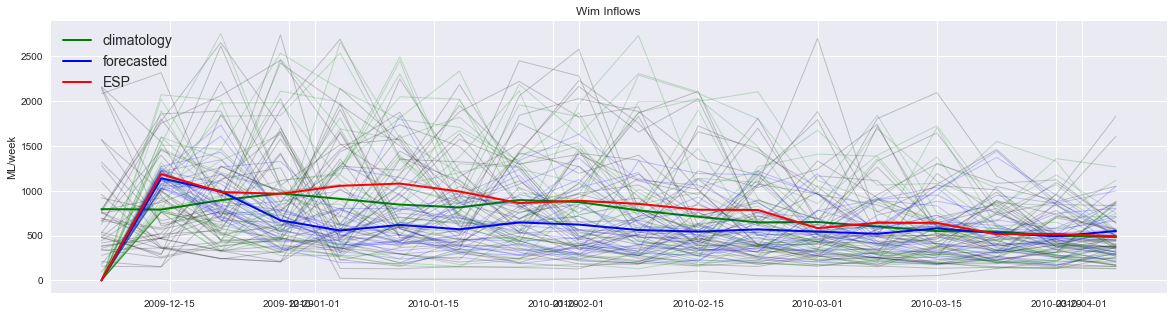

In [176]:
fig,ax = plt.subplots(figsize=(20, 5))
if I_S1_date[-1] <= datetime.datetime(2018,11,5,0,0):
    ax.plot(I_S1_date, I_clim_ens_S1,linewidth = 1,color = 'black',alpha = 0.2)
    ax.plot(I_S1_date, np.mean(I_clim_ens_S1,axis=1),linewidth = 2,color = 'green', label = 'climatology')
ax.plot(I_S1_date, I_S1,linewidth = 1,color = 'blue', alpha = 0.2)    
ax.plot(I_S1_date, np.mean(I_S1,axis = 1),linewidth = 2,color = 'blue', label = 'forecasted')
ax.plot(I_S1_date_ESP, I_ESP_S1,linewidth = 1,color = 'green', alpha = 0.2)    
ax.plot(I_S1_date_ESP, np.mean(I_ESP_S1,axis = 1),linewidth = 2,color = 'red', label = 'ESP')
ax.set_ylabel('ML/week')
ax.set_title('Wim Inflows')
ax.legend(loc='upper left',fontsize=14)
plt.show()

### Observed pumping energy cost

In [177]:
c_RS1 = 50 # £/ML
c_S1D2 = 18 # £/ML
u_RS1_max = 150*7 # ML/week
C_RS1 = np.nan
C_S1D2 = np.nan
# Only available data from 2005 to 2012 (inflows) and 2016 (releases)
if I_S1_date[-1] <= datetime.datetime(2012,5,1,0,0):
    C_RS1,C_S1D2 = Observed_pumping_cost(I_S1_date[0],horizon,c_RS1,c_S1D2)

### Historical/average weekly demand

In [178]:
# East devon (We assume 200 ML/day)
d_D1 = 200 * 7 # ML/week
# Wim releases to Exe river and Maundown demand
u_S1R_,d_D2 = Demand_model(day_ini,horizon)
u_S1R_ = np.transpose(u_S1R_*np.transpose(np.ones(np.shape(I_S1))))
d_D2 = np.transpose(d_D2*np.transpose(np.ones(np.shape(I_S1))))

### Control and target curves
A control curve for Wimbleball and a target curve for Clatworthy are defined according to WW policy. They indicate the need for pumped abstraction and the need for reducing the releases from Wimbleball and Clatworthy respectively.

In [179]:
# Wimbleball
CC_S1 = Control_curve(day_ini,horizon,1)
# Clatworthy
TC_S2 = Control_curve(day_ini,horizon,2)

### Historical reservoir storage envelope

In [153]:
# Wimbleball 1981-2016
SE_S1 = Historical_storage_envelope(day_ini,horizon,1)
SE_S1_max = SE_S1[0]
SE_S1_min = np.transpose(SE_S1[1]*np.transpose(np.ones(np.shape(I_S1))))
# Clatworthy 1981-2016
SE_S2 = Historical_storage_envelope(day_ini,horizon,2)
SE_S2_max = SE_S2[0]
SE_S2_min = np.transpose(SE_S2[1]*np.transpose(np.ones(np.shape(I_S2))))

### Weekly environmental licence

In [154]:
# Wimbleball
env_S1_lic = np.zeros(np.shape(I_S1)) + 1 * 7 # ML/day * days/week = ML/week
# Clatworthy
env_S2_lic = np.zeros(np.shape(I_S1)) + 5 * 7 # ML/day * days/week = ML/week

## Simulation and Optimization
### Parameters

In [155]:
population_size = 20
iterations = 100000

### Optimizer

In [156]:
T = np.size(I_S1_date)

def wimclat_res_sys(vars):
    # Decision vector 1: pumped Wim release to meet the demand in Maundown
    u_S1D2_ = np.transpose(np.array([0]+vars[0:T-1])*np.transpose(np.ones(np.shape(I_S1)))) # pumped release to meet the demand in Maundown

    # Decision vector 2: pumped inflows from River Exe to Wim
    u_RS1_ = np.transpose(np.array([0]+vars[T-1:2*(T-1)])*np.transpose(np.ones(np.shape(I_S1)))) # pumped inflows from River Exe
    # Pumping contraint
    u_RS1_[np.where(CC_S1==0)] = 0 # No pumping when CC_S1 == 0, this is between April and October 

    # Wimbleball system simulation
    # Ensemble mean
    #s_S1, env_S1, u_S1R, u_S1D2, w_S1, e_S1 = reservoir_simulation_2(env_S1_lic, u_S1R_, u_S1D2_, s_min_S1, s_max_S1, s_ini_S1, np.mean(I_S1,axis = 1)+u_RS1_, np.mean(PET,axis = 1), s2elev_S1,elev2area_S1)
    # Ensemble
    s_S1, env_S1, u_S1R, u_S1D2, w_S1, e_S1 = reservoir_simulation_2(env_S1_lic, u_S1R_, u_S1D2_, s_min_S1, s_max_S1, s_ini_S1, I_S1+u_RS1_, PET, s2elev_S1,elev2area_S1)

    # Gravity release from Clat to meet human demand in Maundown (= Maundown demand - Wim release)
    u_S2D2_ = d_D2 - u_S1D2 # Clat gravity release to meet the demand in Maundown (Clat releases = demand in Maundown - Wim releases)

    # Clatworthy system simulation
    # Ensemble mean
    #s_S2,env_S2, u_S2D2, w_S2, e_S2 = reservoir_simulation_1(env_S2_lic, u_S2D2_, s_min_S2, s_max_S2, s_ini_S2, np.mean(I_S2,axis = 1), np.mean(PET,axis = 1), s2elev_S2,elev2area_S2)
    # Ensemble
    s_S2,env_S2, u_S2D2, w_S2, e_S2 = reservoir_simulation_1(env_S2_lic, u_S2D2_, s_min_S2, s_max_S2, s_ini_S2, I_S2, PET, s2elev_S2,elev2area_S2)

    # Objective functions
    # Objective 0: To minimize pumping cost
    value0 = np.sum(np.mean(u_RS1_,axis = 1))*c_RS1 + np.sum(np.mean(u_S1D2,axis = 1))*c_S1D2  # Minimize pumped abstractions and releases (to Maundown)
    # Objective 1: To maximize the Wim + Clat resource availability at the 1st April
    # 5. Wim storage at 1 April = Wim storage capacity
    s_S1_1Apr = SE_S1_max[-1]
    # 6. Clat storage at 1 April = Wim storage capacity
    s_S2_1Apr = SE_S2_max[-1]
    value1 = np.mean(s_S1_1Apr-s_S1[-1]) + np.mean(s_S2_1Apr-s_S2[-1])

    # Optimization constraints
    # 1. Clat gravity releases <=36*7 Ml/week
    u_S2D2_max = 36*7 # ML/week, from 1 April to 31 July, max capacity
    #u_S2D2_max = 15*7 # ML/week, from 1 August to 30 March, limited releases to assure the resource availabilty in Clatworthy before the dry season
    # 2. Minimum flow to be guaranteed downstream of EX abstraction point
    # 3. Wim storage level not lower than the historical minimum (envelope of historical storage values 1986-2016)
    # 4. Clat storage level not lower than the historical minimum (envelope of historical storage values 1986-2016)
#    if I_S1_date[-1] <= datetime.datetime(2016,12,5,0,0) and I_S1_date[0] >= datetime.datetime(2005,1,1,0,0):
#        # 5. Wim storage at 1 April = Observed level at 1 April at the year of study
#        s_S1_1Apr = s_obs_S1[-1]
#        # 6. Clat storage at 1 April = Observed level at 1 April at the year of study
#        s_S2_1Apr = s_obs_S2[-1]
#    else:
#        # 5. Wim storage at 1 April = Wim storage capacity
#    s_S1_1Apr = SE_S1_max[-1]
#        # 6. Clat storage at 1 April = Wim storage capacity
#    s_S2_1Apr = SE_S2_max[-1]

    constraints = [u_S2D2_max - np.max(u_S2D2_),np.min((I_R1-1.16*86.4*7)/2-u_RS1_),
                   np.mean(s_S1-SE_S1_min),np.mean(s_S2-SE_S2_min)]

    return [value0,value1],constraints

problem = Problem(2*(T-1), 2, 4) # (total length of the variable vectors, number of objective functions, number of constraints)
real1 = Real(0, 45*7)
real2 = Real(0, 150*7)
problem.types[:] = [real1]*(T-1) + [real2]*(T-1)
problem.constraints[:] = ">=0", ">=0", ">=0", ">=0"
problem.function = wimclat_res_sys

algorithm = NSGAII_v3(problem,population_size)
algorithm.run(iterations) 

### Results

In [157]:
results_objective_0 = np.array([algorithm.result[i].objectives[0] for i in range(population_size)])
results_objective_1 = np.array([algorithm.result[i].objectives[1] for i in range(population_size)])

solutions1 = np.array([[0]+algorithm.result[i].variables[0:T-1] for i in range(population_size)])
solutions2 = np.array([[0]+algorithm.result[i].variables[T-1:2*(T-1)] for i in range(population_size)])
solutions2[:,np.where(CC_S1==0)] = 0

In [158]:
if decision.get_interact_value() == "Max res":
    k = np.where(results_objective_1 == np.min(results_objective_1))[0][0] # Minimum storage volume different with full storage on 1 April   (Percentile 0)    
elif decision.get_interact_value() == "Max res - Balanced":
    k = np.where(np.abs(results_objective_1 - np.percentile(results_objective_1,25)) == np.min(np.abs(results_objective_1 - np.percentile(results_objective_1,25))))[0][0] # (Percentile 25) 
elif decision.get_interact_value() == "Balanced - Mean":
    k = np.where(np.abs(results_objective_1 - np.mean(results_objective_1)) == np.min(np.abs(results_objective_1 - np.mean(results_objective_1))))[0][0] # Mean storage volume different with full storage on 1 April
elif decision.get_interact_value() == "Balanced - Median":
    k = np.where(np.abs(results_objective_1 - np.median(results_objective_1)) == np.min(np.abs(results_objective_1 - np.median(results_objective_1))))[0][0] # Median storage volume different with full storage on 1 April
elif decision.get_interact_value() == "Min pump - Balanced":
    k = np.where(np.abs(results_objective_1 - np.percentile(results_objective_1,75)) == np.min(np.abs(results_objective_1 - np.percentile(results_objective_1,75))))[0][0] # (Percentile 75) 
elif decision.get_interact_value() == "Min pump":
    k = np.where(results_objective_0 == np.min(results_objective_0))[0][0] # Minimun pumping energy cost
    

#### 1) Pre-evaluation
##### Pareto front

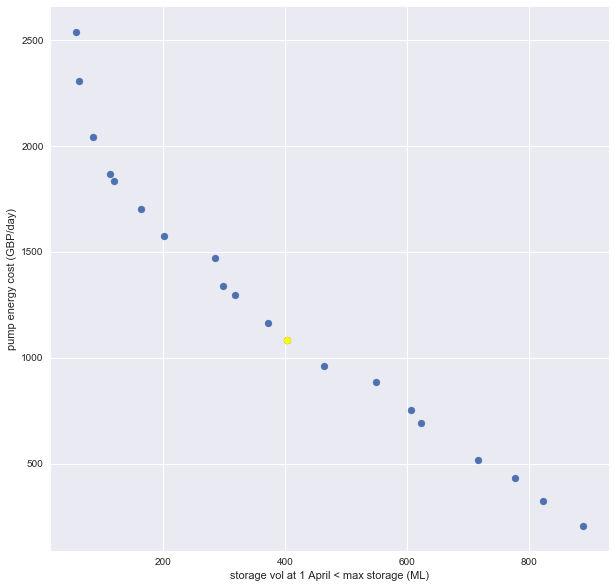

In [159]:
fig,ax = plt.subplots(figsize=(10, 10))
ax.scatter(results_objective_1[:],results_objective_0[:]/T/7)
ax.scatter(results_objective_1[k],results_objective_0[k]/T/7,color='yellow')
ax.set_ylabel('pump energy cost (GBP/day)')
ax.set_xlabel('storage vol at 1 April < max storage (ML)')
plt.show()

#### 2) Post-evaluation
##### Forecasted vs observed inflows

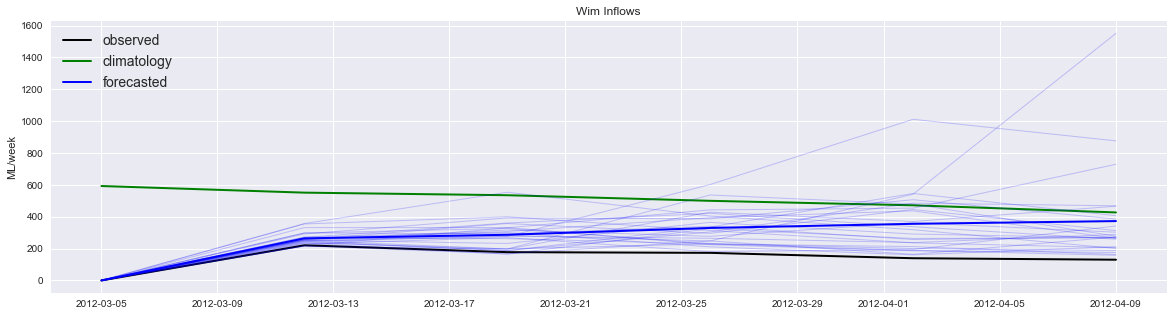

In [161]:
fig,ax0 = plt.subplots(figsize=(20, 5))
if I_S1_date[-1] <= datetime.datetime(2018,11,5,0,0):
    ax0.plot(I_S1_date, I_obs_S1,linewidth = 2,color = 'black', label = 'observed')
    ax0.plot(I_S1_date, np.mean(I_clim_ens_S1,axis=1),linewidth = 2,color = 'green', label = 'climatology')
ax0.plot(I_S1_date, I_S1,linewidth = 1,color = 'blue', alpha = 0.2)    
ax0.plot(I_S1_date, np.mean(I_S1,axis = 1),linewidth = 2,color = 'blue', label = 'forecasted')
ax0.set_ylabel('ML/week')
ax0.set_title('Wim Inflows')
ax0.legend(loc='upper left',fontsize=14)
plt.show()

##### Pumping cost

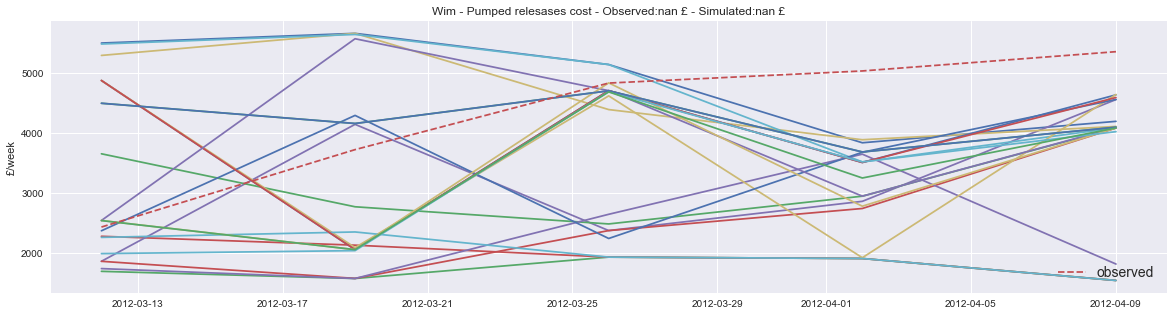

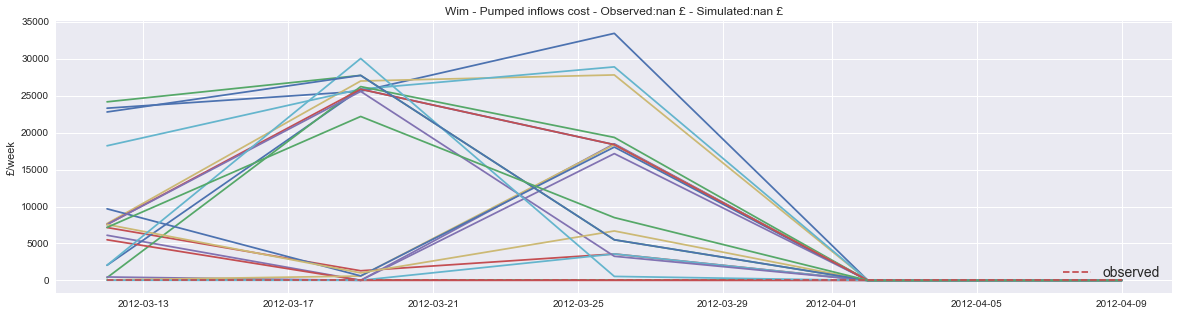

Wim - Total pumping cost - Observed:nan £ - Simulated:nan £


In [162]:
fig,ax0 = plt.subplots(figsize=(20, 5))
fig,ax2 = plt.subplots(figsize=(20, 5))

for i in range(population_size):
    u_S1D2_ = solutions1[i]

    u_RS1 = solutions2[i]
    u_RS1_ = np.maximum(np.minimum(u_RS1,(I_obs_R1-1.16*86.4*7)/2),0)
    u_RS1_[0] = np.nan

    # Wimbleball system simulation
    s_S1, env_S1, u_S1R, u_S1D2, w_S1, e_S1 = reservoir_simulation_2(env_S1_lic, u_S1R_, u_S1D2_, s_min_S1, s_max_S1, s_ini_S1, I_obs_S1+u_RS1_, PET, s2elev_S1,elev2area_S1)

    d_D2_obs = np.reshape(np.mean(d_D2,axis=1),[np.size(np.mean(d_D2,axis=1)),1])

    u_S1D2[0] = np.nan
    u_S2D2_ = d_D2_obs - u_S1D2

    # Clatworthy system simulation
    s_S2,env_S2, u_S2D2, w_S2, e_S2 = reservoir_simulation_1(env_S2_lic, u_S2D2_, s_min_S2, s_max_S2, s_ini_S2, I_obs_S2, PET, s2elev_S2,elev2area_S2)

    ax0.plot(I_S1_date, u_S1D2*c_S1D2)
    ax2.plot(I_S1_date, u_RS1_*c_RS1)

ax0.plot(I_S1_date, C_S1D2,'--',label = 'observed')
ax2.plot(I_S1_date, C_RS1,'--',label = 'observed')
ax0.set_ylabel('£/week')
ax0.set_title('Wim - Pumped relesases cost - Observed:'+str(np.sum(C_S1D2))+' £ - Simulated:'+str(np.sum(u_S1D2)*c_S1D2)+' £')
ax2.set_ylabel('£/week')
ax2.set_title('Wim - Pumped inflows cost - Observed:'+str(np.sum(C_RS1))+' £ - Simulated:'+str(np.sum(u_RS1_)*c_RS1)+' £')
ax0.legend(loc='lower right',fontsize=14)
ax2.legend(loc='lower right',fontsize=14)
plt.show()
print('Wim - Total pumping cost - Observed:'+str(np.sum(C_S1D2+C_RS1))+' £ - Simulated:'+str(np.sum(u_RS1_)*c_RS1+np.sum(u_S1D2)*c_S1D2)+' £')

##### Storage volume and supply deficit

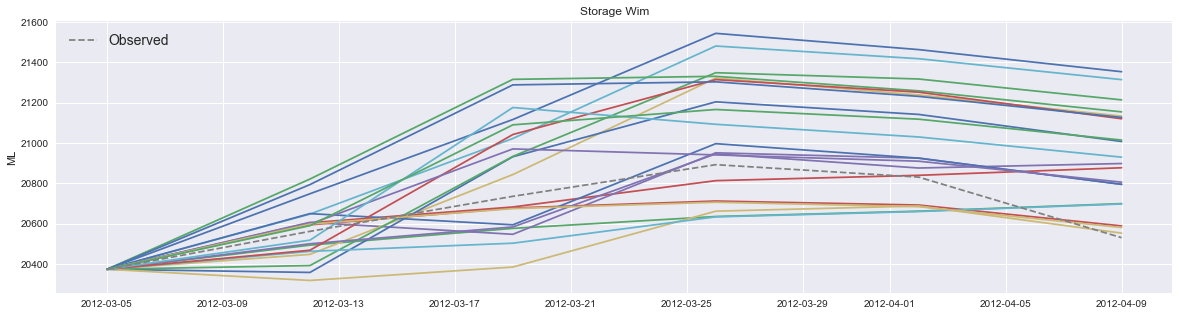

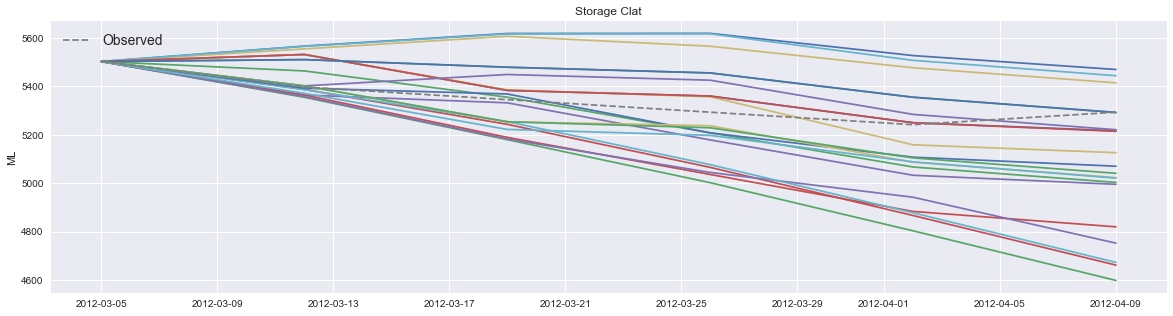

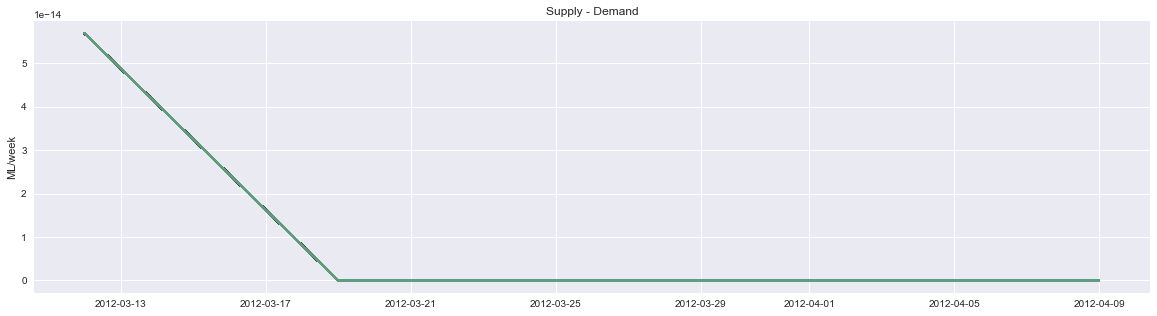

In [163]:
if I_S1_date[-1] <= datetime.datetime(2018,11,5,0,0):
    fig,ax1 = plt.subplots(figsize=(20, 5))
    fig,ax3 = plt.subplots(figsize=(20, 5))
    fig,ax4 = plt.subplots(figsize=(20, 5))

#    ax1.fill_between(I_S1_date, SE_S1_max,SE_S1_min,color = 'green', label = 'Historical envelope', alpha = 0.5)
#    ax1.plot(I_S1_date, CC_S1, '--',color = 'black', label = 'Control curve', alpha = 0.2)
#    ax3.fill_between(I_S1_date, SE_S2_max,SE_S2_min,color = 'green', label = 'Historical envelope', alpha = 0.5)
#    ax3.plot(I_S1_date, TC_S2, '--',color = 'black', label = 'Target curve', alpha = 0.2)
    for i in range(population_size):
        u_S1D2_ = solutions1[i]

        u_RS1 = solutions2[i]
        u_RS1_ = np.maximum(np.minimum(u_RS1,(I_obs_R1-1.16*86.4*7)/2),0)
        u_RS1_[0] = np.nan

        # Wimbleball system simulation
        s_S1, env_S1, u_S1R, u_S1D2, w_S1, e_S1 = reservoir_simulation_2(env_S1_lic, u_S1R_, u_S1D2_, s_min_S1, s_max_S1, s_ini_S1, I_obs_S1+u_RS1_, PET, s2elev_S1,elev2area_S1)

        d_D2_obs = np.reshape(np.mean(d_D2,axis=1),[np.size(np.mean(d_D2,axis=1)),1])

        u_S1D2[0] = np.nan
        u_S2D2_ = d_D2_obs - u_S1D2

        # Clatworthy system simulation
        s_S2,env_S2, u_S2D2, w_S2, e_S2 = reservoir_simulation_1(env_S2_lic, u_S2D2_, s_min_S2, s_max_S2, s_ini_S2, I_obs_S2, PET, s2elev_S2,elev2area_S2)

        ax1.plot(I_S1_date, s_S1)
        ax3.plot(I_S1_date, s_S2)
        ax4.plot(I_S1_date,(u_S1D2+u_S2D2)-d_D2)

    if I_S1_date[-1] <= datetime.datetime(2016,12,5,0,0):
        ax1.plot(I_S1_date, s_obs_S1,'--',color = 'grey',label = 'Observed')
    ax1.set_ylabel('ML')
    ax1.set_title('Storage Wim')
    if I_S1_date[-1] <= datetime.datetime(2016,12,5,0,0):
        ax3.plot(I_S1_date, s_obs_S2,'--',color = 'grey',label = 'Observed')
    ax3.set_ylabel('ML')
    ax3.set_title('Storage Clat')
    ax4.set_ylabel('ML/week')
    ax4.set_title('Supply - Demand')
    ax1.legend(loc='upper left',fontsize=14)
    ax3.legend(loc='upper left',fontsize=14)
    plt.show()

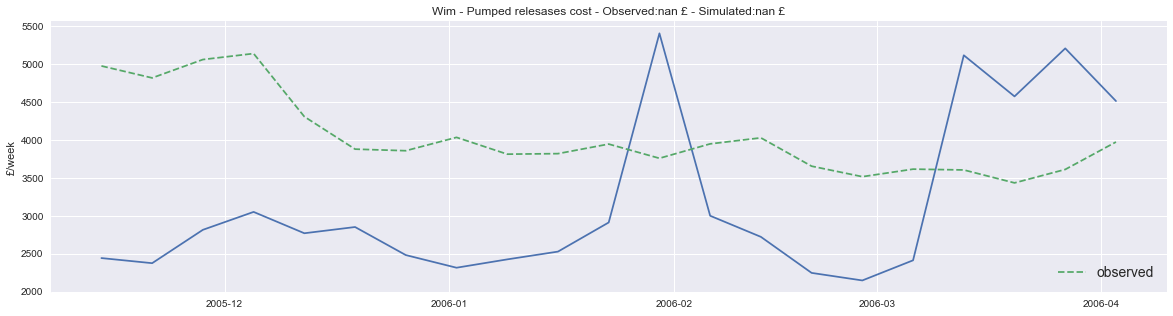

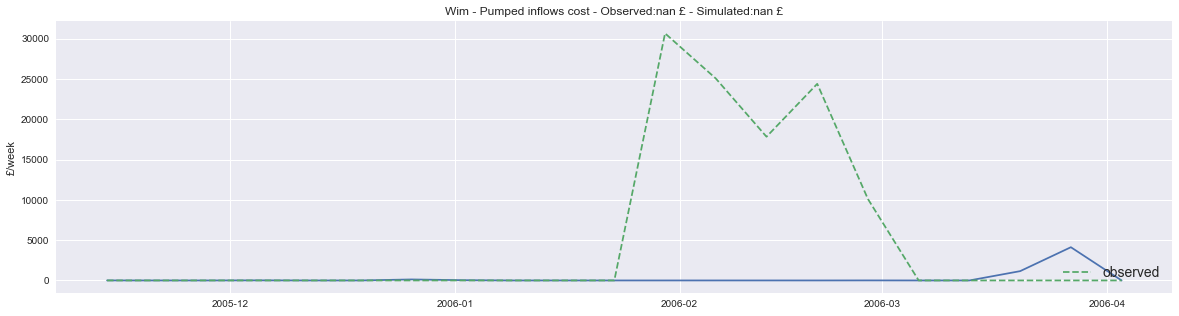

Wim - Total pumping cost - Observed:nan £ - Simulated:nan £


In [118]:
fig,ax0 = plt.subplots(figsize=(20, 5))
fig,ax2 = plt.subplots(figsize=(20, 5))

u_S1D2_ = solutions1[i]

u_RS1 = solutions2[i]
u_RS1_ = np.maximum(np.minimum(u_RS1,(I_obs_R1-1.16*86.4*7)/2),0)
u_RS1_[0] = np.nan

# Wimbleball system simulation
s_S1, env_S1, u_S1R, u_S1D2, w_S1, e_S1 = reservoir_simulation_2(env_S1_lic, u_S1R_, u_S1D2_, s_min_S1, s_max_S1, s_ini_S1, I_obs_S1+u_RS1_, PET, s2elev_S1,elev2area_S1)

d_D2_obs = np.reshape(np.mean(d_D2,axis=1),[np.size(np.mean(d_D2,axis=1)),1])

u_S1D2[0] = np.nan
u_S2D2_ = d_D2_obs - u_S1D2

# Clatworthy system simulation
s_S2,env_S2, u_S2D2, w_S2, e_S2 = reservoir_simulation_1(env_S2_lic, u_S2D2_, s_min_S2, s_max_S2, s_ini_S2, I_obs_S2, PET, s2elev_S2,elev2area_S2)

ax0.plot(I_S1_date, u_S1D2*c_S1D2)
ax2.plot(I_S1_date, u_RS1_*c_RS1)

ax0.plot(I_S1_date, C_S1D2,'--',label = 'observed')
ax2.plot(I_S1_date, C_RS1,'--',label = 'observed')
ax0.set_ylabel('£/week')
ax0.set_title('Wim - Pumped relesases cost - Observed:'+str(np.sum(C_S1D2))+' £ - Simulated:'+str(np.sum(u_S1D2)*c_S1D2)+' £')
ax2.set_ylabel('£/week')
ax2.set_title('Wim - Pumped inflows cost - Observed:'+str(np.sum(C_RS1))+' £ - Simulated:'+str(np.sum(u_RS1_)*c_RS1)+' £')
ax0.legend(loc='lower right',fontsize=14)
ax2.legend(loc='lower right',fontsize=14)
plt.show()
print('Wim - Total pumping cost - Observed:'+str(np.sum(C_S1D2+C_RS1))+' £ - Simulated:'+str(np.sum(u_RS1_)*c_RS1+np.sum(u_S1D2)*c_S1D2)+' £')

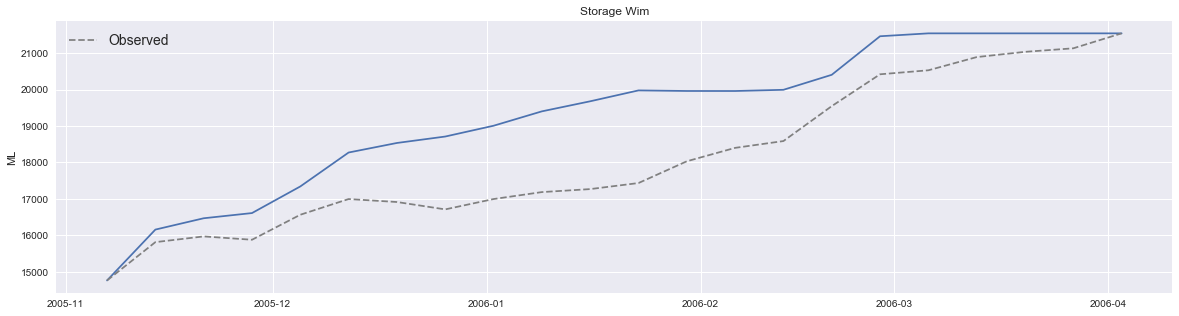

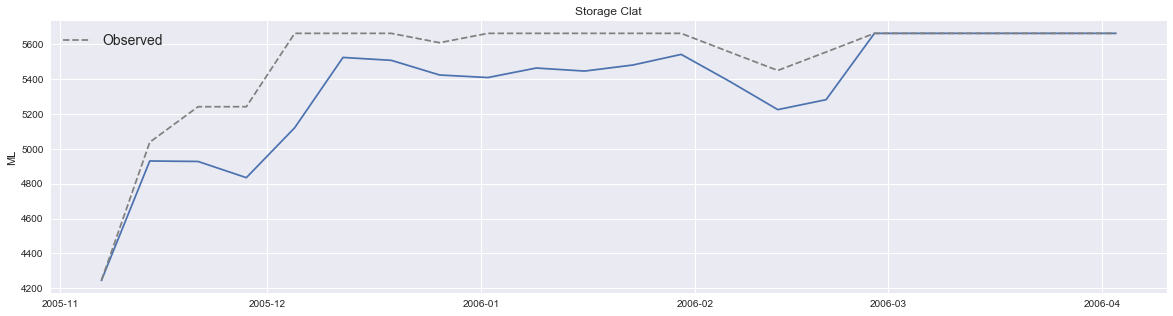

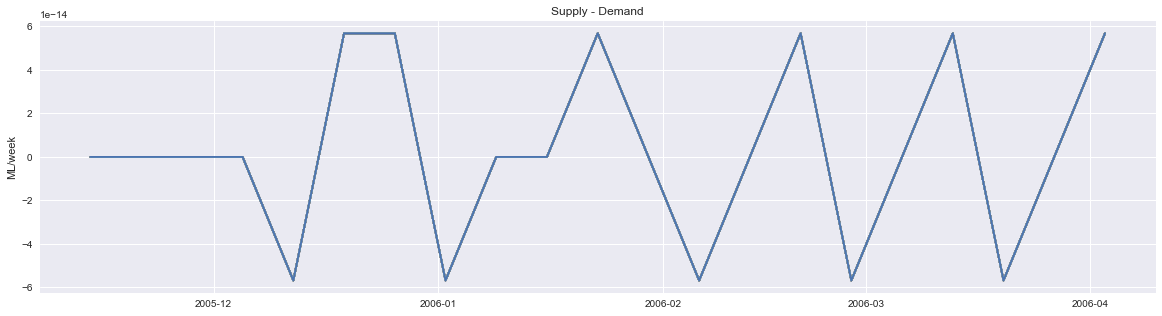

In [119]:
if I_S1_date[-1] <= datetime.datetime(2018,11,5,0,0):
    fig,ax1 = plt.subplots(figsize=(20, 5))
    fig,ax3 = plt.subplots(figsize=(20, 5))
    fig,ax4 = plt.subplots(figsize=(20, 5))

#    ax1.fill_between(I_S1_date, SE_S1_max,SE_S1_min,color = 'green', label = 'Historical envelope', alpha = 0.5)
#    ax1.plot(I_S1_date, CC_S1, '--',color = 'black', label = 'Control curve', alpha = 0.2)
#    ax3.fill_between(I_S1_date, SE_S2_max,SE_S2_min,color = 'green', label = 'Historical envelope', alpha = 0.5)
#    ax3.plot(I_S1_date, TC_S2, '--',color = 'black', label = 'Target curve', alpha = 0.2)
    u_S1D2_ = solutions1[i]

    u_RS1 = solutions2[i]
    u_RS1_ = np.maximum(np.minimum(u_RS1,(I_obs_R1-1.16*86.4*7)/2),0)
    u_RS1_[0] = np.nan

    # Wimbleball system simulation
    s_S1, env_S1, u_S1R, u_S1D2, w_S1, e_S1 = reservoir_simulation_2(env_S1_lic, u_S1R_, u_S1D2_, s_min_S1, s_max_S1, s_ini_S1, I_obs_S1+u_RS1_, PET, s2elev_S1,elev2area_S1)

    d_D2_obs = np.reshape(np.mean(d_D2,axis=1),[np.size(np.mean(d_D2,axis=1)),1])

    u_S1D2[0] = np.nan
    u_S2D2_ = d_D2_obs - u_S1D2

    # Clatworthy system simulation
    s_S2,env_S2, u_S2D2, w_S2, e_S2 = reservoir_simulation_1(env_S2_lic, u_S2D2_, s_min_S2, s_max_S2, s_ini_S2, I_obs_S2, PET, s2elev_S2,elev2area_S2)

    ax1.plot(I_S1_date, s_S1)
    ax3.plot(I_S1_date, s_S2)
    ax4.plot(I_S1_date,(u_S1D2+u_S2D2)-d_D2)

    if I_S1_date[-1] <= datetime.datetime(2016,12,5,0,0):
        ax1.plot(I_S1_date, s_obs_S1,'--',color = 'grey',label = 'Observed')
    ax1.set_ylabel('ML')
    ax1.set_title('Storage Wim')
    if I_S1_date[-1] <= datetime.datetime(2016,12,5,0,0):
        ax3.plot(I_S1_date, s_obs_S2,'--',color = 'grey',label = 'Observed')
    ax3.set_ylabel('ML')
    ax3.set_title('Storage Clat')
    ax4.set_ylabel('ML/week')
    ax4.set_title('Supply - Demand')
    ax1.legend(loc='upper left',fontsize=14)
    ax3.legend(loc='upper left',fontsize=14)
    plt.show()

##### Pareto front

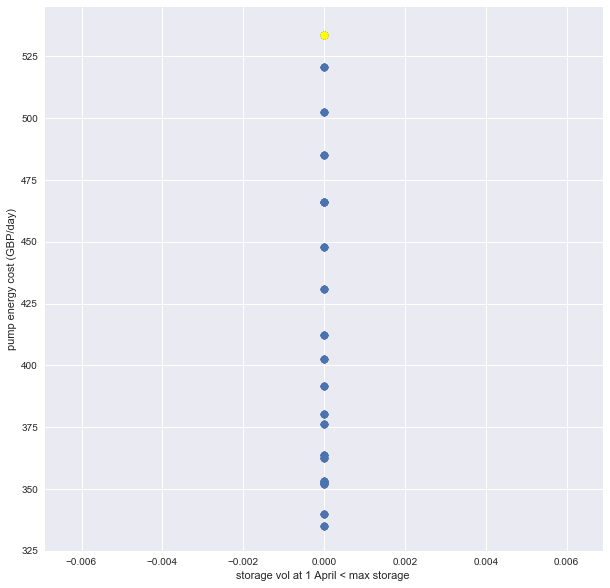

In [120]:
if I_S1_date[-1] <= datetime.datetime(2018,11,5,0,0):
    values0 = np.zeros(np.shape(solutions1))
    values1 = np.zeros(np.shape(solutions1))

    fig,axp = plt.subplots(figsize=(10, 10))

    for i in range(population_size):
        u_S1D2_ = solutions1[i]

        u_RS1 = solutions2[i]
        u_RS1_ = np.maximum(np.minimum(u_RS1,(I_obs_R1-1.16*86.4*7)/2),0)
        u_RS1_[0] = np.nan

        # Wimbleball system simulation
        s_S1, env_S1, u_S1R, u_S1D2, w_S1, e_S1 = reservoir_simulation_2(env_S1_lic, u_S1R_, u_S1D2_, s_min_S1, s_max_S1, s_ini_S1, I_obs_S1+u_RS1_, PET, s2elev_S1,elev2area_S1)

        d_D2_obs = np.reshape(np.mean(d_D2,axis=1),[np.size(np.mean(d_D2,axis=1)),1])

        u_S1D2[0] = np.nan
        u_S2D2_ = d_D2_obs - u_S1D2

        # Clatworthy system simulation
        s_S2,env_S2, u_S2D2, w_S2, e_S2 = reservoir_simulation_1(env_S2_lic, u_S2D2_, s_min_S2, s_max_S2, s_ini_S2, I_obs_S2, PET, s2elev_S2,elev2area_S2)

        values0[i] = np.nansum(u_RS1_)*c_RS1 + np.nansum(u_S1D2)*c_S1D2  # Minimize pumped abstractions and releases (to Maundown)
        values1[i] = SE_S1_max[-1]-s_S1[-1]

    axp.scatter(values1[:],values0/T/7)
    axp.scatter(values1[k],values0[k]/T/7,color='yellow')
    axp.set_ylabel('pump energy cost (GBP/day)')
    axp.set_xlabel('storage vol at 1 April < max storage ')

    plt.show()